In [1]:
# Use this cell to download the dataset
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXX"
!kaggle datasets download -d gsimonx37/letterboxd/ -f actors.csv
!unzip actors.csv.zip

/bin/bash: line 1: kaggle: command not found
unzip:  cannot find or open actors.csv.zip, actors.csv.zip.zip or actors.csv.zip.ZIP.


In [7]:
!pip install mmh3

import mmh3
import statistics
import random
import csv
from collections import Counter
import matplotlib.pyplot as plt
#set this variable to use the full data or downsample to reduce time execution
DOWNSAMPLE = False

# Class that implements Flajolet-Martin algorithm

In [3]:
class StreamFM32:
  """ An instance of this class keeps track of the estimate of distinct element seen
      in a stream so far, according to the Flajolet-Martin algorithm, using 4 bytes
      hashes. """

  def __init__(self,nhash : int):
    """ nhash : int
          the number of hash functions used to perform an estimate
        Raises ValueError if nhash is <= 0 """
    if nhash <= 0:
      raise ValueError(f"Parameter must be > 0: got nhash = {nhash}")
    self.nhash = nhash
    self.tail_lengths = [0] * nhash

  def __trailing_zeros(self, x : int):
    """ Counts and returns the number of trailing zeros in the binary representation of x.
        Assumes 32 bit integers as input because the hash values generated for
        the Flajolet-Martin algorithm will be 32 bit longs. """
    count = 0
    for _ in range(32):
        if x & 1 == 1: break
        count += 1
        x >>= 1
    return count

  def update_tail_lengths(self, key : str):
    """ Updates each hash function's maximum recorded tail length,
        hashing the specified key. """
    for i in range(self.nhash):
        hash = mmh3.hash(key,i) # use i as seed for reproducibility
        self.tail_lengths[i] = max(self.tail_lengths[i],self.__trailing_zeros(hash))

  def get_estimate(self, groupSize : int):
    """ Returns the estimate of the number of distinct elements according to these steps:
        - split self.tail_lengths in groups of size = groupSize,
        - map each value t in the groups to 2^t
        - take the average of each group,
        - return the median of the averages.
        If m = the number of distinct elements, a good value for groupSize is a
        small multiple of log_2(m)
        Raises ValueError if groupSize is <= 0
    """
    if groupSize <= 0:
      raise ValueError(f"Parameter must be > 0: got groupSize = {groupSize}")
    averages = []
    estimates = [2**t for t in self.tail_lengths]
    for i in range(len(self.tail_lengths)//groupSize):
      average = statistics.mean(estimates[i*groupSize:groupSize*(i+1)])
      averages.append(average)
    if len(self.tail_lengths) % groupSize != 0:
      start = (len(self.tail_lengths) // groupSize) * groupSize
      average = statistics.mean(estimates[start:])
      averages.append(average)

    return round(statistics.median(averages))


# Class that implements Alon-Matias-Szegedy algorithm

In [4]:

class StreamAMS:
  """ An instance of this class is used to hold and update the necessary
      variables for the Alon-Matias-Szegedy algorithm, in order to
      estimate moments of order > 1
      (0th moment can be estimated with the StreamFM32 class, while 1st moment
      is just the length of the stream)"""
  def __init__(self,nvariables : int, seed : int = None):
    """ nvariables : int
          the number of variables to be used for the AMS algorithm.
        seed : int
          the seed used to generate the random numbers. If not specified, the
          current time or another form of entropy is used to initialize it.
    Raises ValueError if nvariables is <= 0
    """
    if nvariables <= 0:
      raise ValueError(f"Parameter must be > 0: got nvariables = {nvariables}")
    self.nvariables = nvariables
    self.variables = []
    self.streamLength = 0
    self.random = random.Random()
    if seed:
      self.random = random.Random(seed)


  def __increase_value(self, element : str):
    """ Increases by 1 the value of all variables which element is == to the
        input parameter
    """
    for i in range(len(self.variables)):
      e, v = self.variables[i]
      if e == element:
        self.variables[i][1] += 1

  def update_variables(self, element : str):
    """ Updates the estimation variables according to AMS algorithm,
        when the specified element appears in the stream"""
    self.streamLength += 1
    # fill the n variables with the first n elements if at start of the algorithm
    if len(self.variables) < self.nvariables :
      self.variables.append([element,0])
    # else pick the next position with probability nvariables/streamLength
    elif self.random.randint(1,self.streamLength) <= self.nvariables:
      # pick the position and throw out some variable with uniform probability
      i = self.random.randint(0,self.nvariables-1)
      self.variables[i] = [element,0]
      # else do nothing. In all cases, increase the values of the variables
    self.__increase_value(element)

  def get_estimate(self, moment_order : int):
    """ Returns the average of each variable's estimate, that is:
        streamLength * (v^k - (v-1)^k) where v is the value of the variable and
        k is the specified moment order.
        Raises ValueError if moment_order is <= 1 or if update_variables was never
        called
    """
    err = None
    if moment_order <= 1 :
      err = f"Moment_order must be > 1, got moment_order = {moment_order}"
    if len(self.variables) == 0:
      err = "Can't compute estimate: no stream element has been seen. Call update_variables first."
    if err:
      raise ValueError(err)
    estimates = [self.streamLength*(v**moment_order - (v-1)**moment_order) for
                 _, v in self.variables]
    return round(statistics.mean(estimates))


# Experiments with different number of hash functions/variables

In [8]:
rowCount = 0

time = []
true_distincts = []
true_second_moments = []
parameters = [1,16,32,64,128,256,512,1024,2048]
distinct_estimates = [[] for _ in range(len(parameters))]
second_moment_estimates = [[] for _ in range(len(parameters))]
distinct_estimators = [StreamFM32(p) for p in parameters]
moment_estimators = [StreamAMS(p,42) for p in parameters]
count = Counter()
with open("actors.csv") as actors:
  reader = csv.reader(actors)
  next(reader, None)  # skip the header
  for row in reader:
    rowCount += 1
    count[row[1]] +=1

    for i in range(len(parameters)):
      distinct_estimators[i].update_tail_lengths(row[1])

      moment_estimators[i].update_variables(row[1])
      if rowCount % 5000 == 0:
        distinct_estimates[i].append(distinct_estimators[i].get_estimate(4))
        second_moment_estimates[i].append(moment_estimators[i].get_estimate(2))
    if rowCount % 5000 == 0:
      true_distincts.append(len(count))
      true_second_moments.append(sum(v**2 for v in count.values()))
      time.append(rowCount)
    if DOWNSAMPLE and rowCount == 100_000:
      break


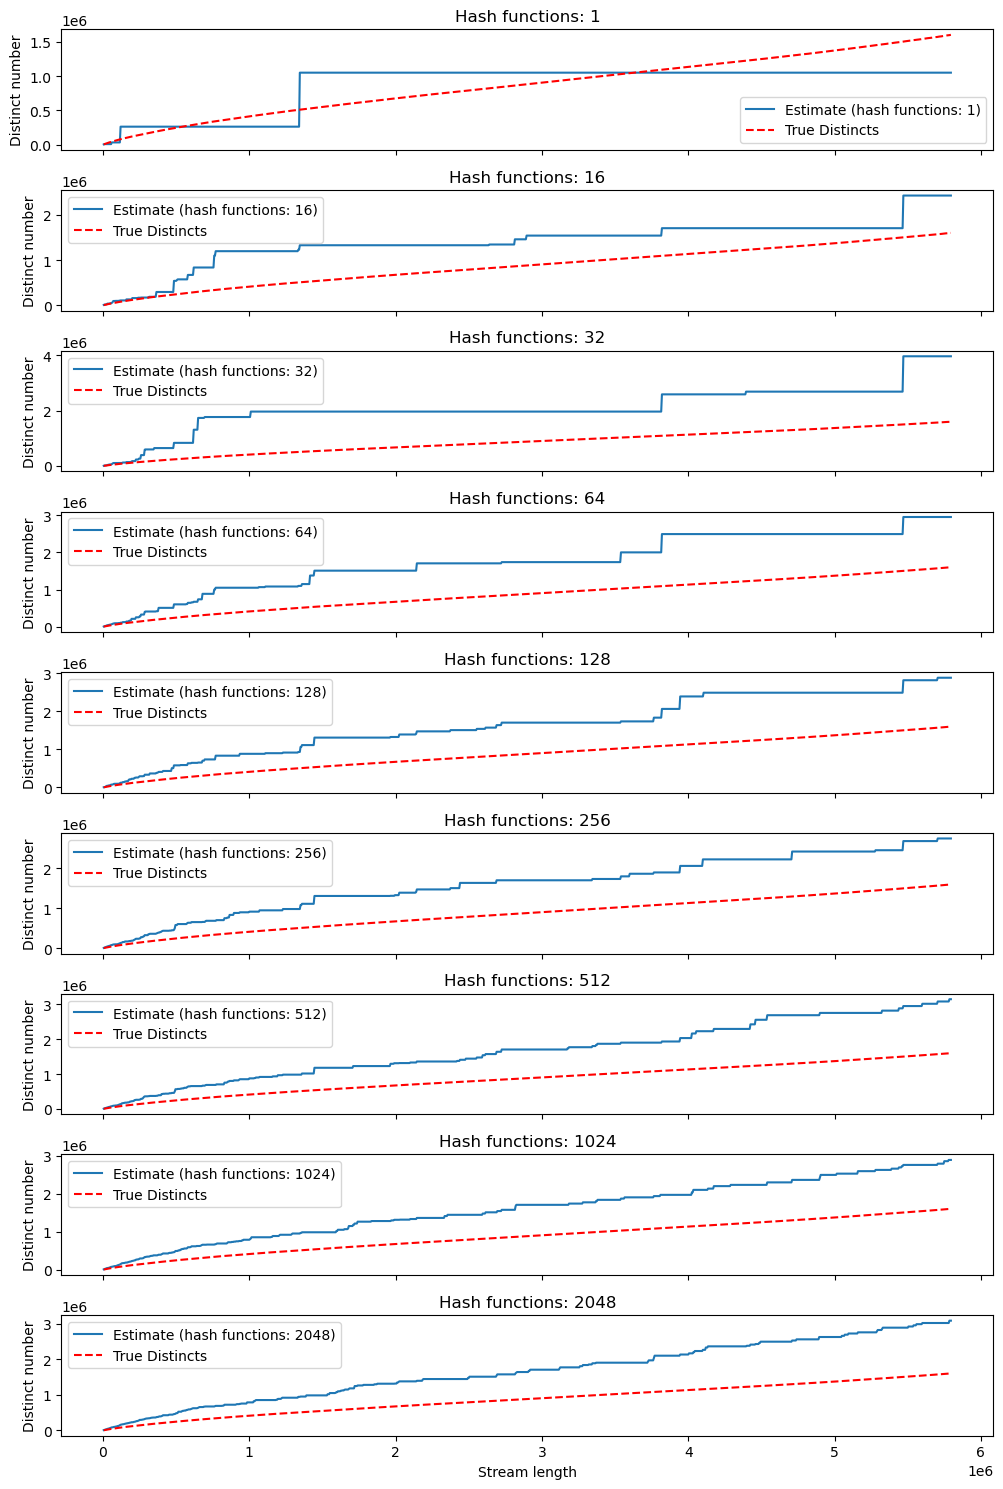

In [17]:
fig, axes = plt.subplots(len(parameters), 1, figsize=(10, 15), sharex=True)

for i, param in enumerate(parameters):
    axes[i].plot(time, distinct_estimates[i], label=f'Estimate (hash functions: {param})')
    axes[i].plot(time, true_distincts, label='True Distincts', linestyle='--', color='red')
    axes[i].set_title(f'Hash functions: {param}')
    axes[i].set_ylabel('Distinct number')
    axes[i].legend()

axes[-1].set_xlabel('Stream length')
plt.tight_layout()
plt.show()

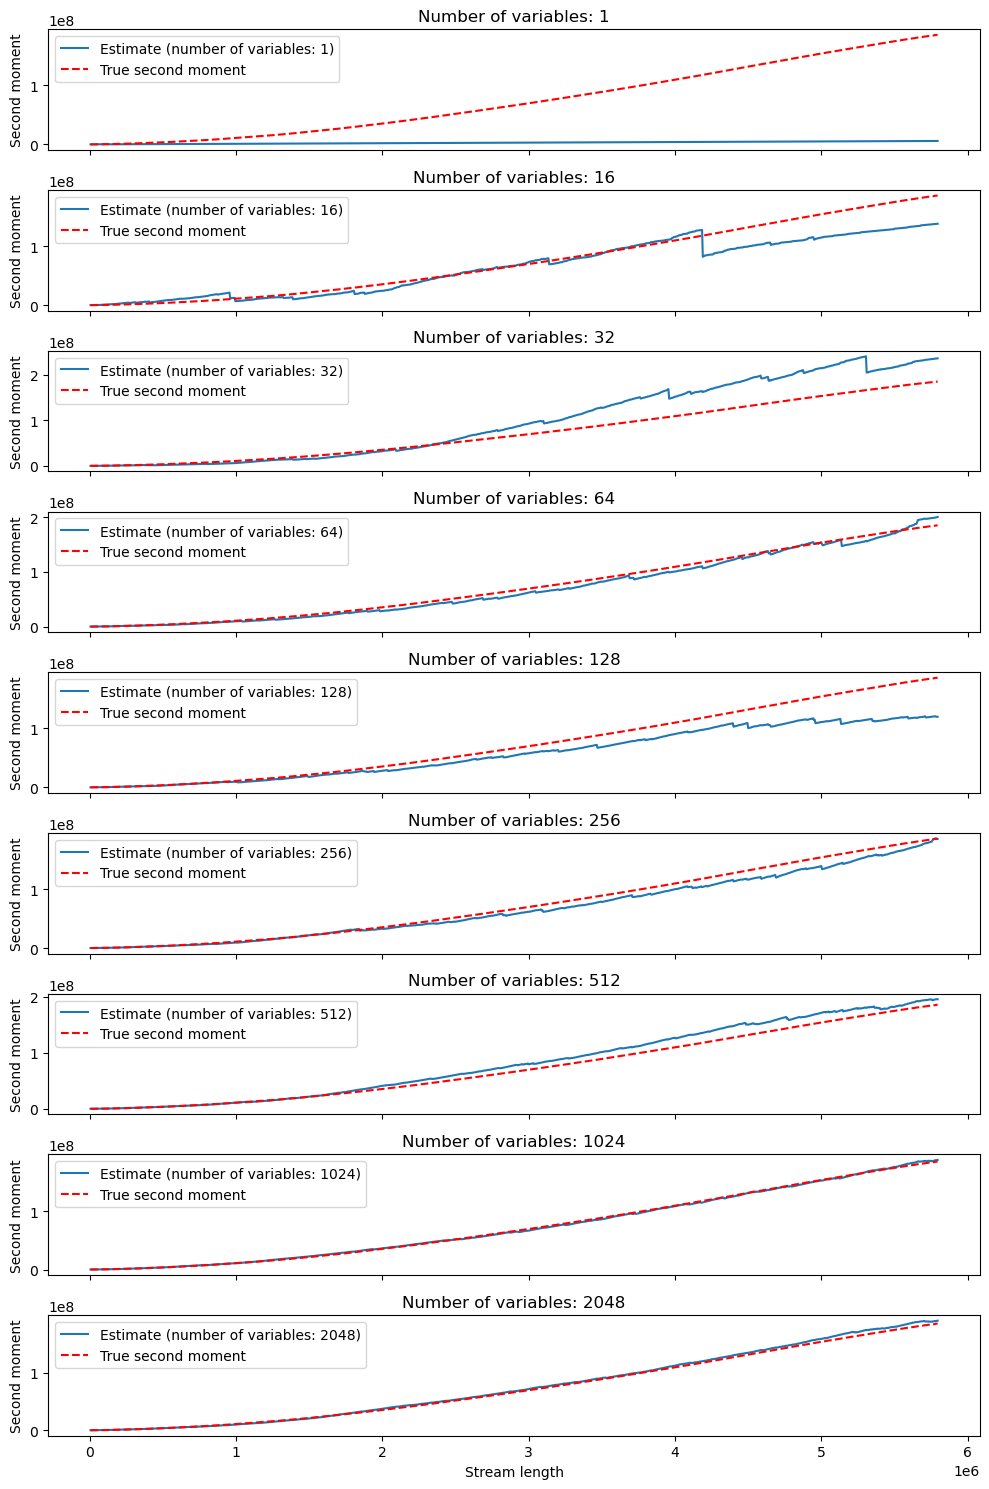

In [19]:
fig, axes = plt.subplots(len(parameters), 1, figsize=(10, 15), sharex=True)

for i, param in enumerate(parameters):
    axes[i].plot(time, second_moment_estimates[i], label=f'Estimate (number of variables: {param})')
    axes[i].plot(time, true_second_moments, label='True second moment', linestyle='--', color='red')
    axes[i].set_title(f'Number of variables: {param}')
    axes[i].set_ylabel('Second moment')
    axes[i].legend()

axes[-1].set_xlabel('Stream length')
plt.tight_layout()
plt.show()

# Plot of the distinct estimate at the end of the stream, experimenting different group sizes

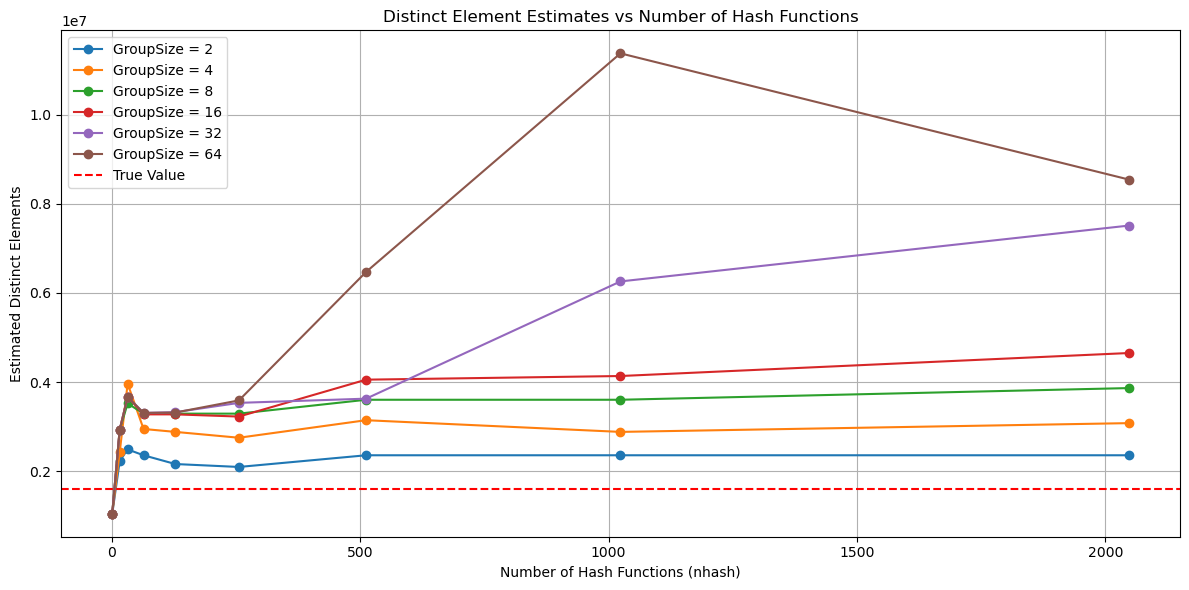

In [20]:
true_distinct_count = len(count)

group_sizes = [2, 4, 8, 16, 32,64]


group_estimates = {group_size: [] for group_size in group_sizes}

for group_size in group_sizes:
    for estimator in distinct_estimators:
        estimate = estimator.get_estimate(group_size)
        group_estimates[group_size].append(estimate)


plt.figure(figsize=(12, 6))

for group_size in group_sizes:
    plt.plot(parameters, group_estimates[group_size], marker='o', label=f"GroupSize = {group_size}")

plt.axhline(y=true_distinct_count, color='r', linestyle='--', label="True Value")
plt.title("Distinct Element Estimates vs Number of Hash Functions")
plt.xlabel("Number of Hash Functions (nhash)")
plt.ylabel("Estimated Distinct Elements")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# 2nd moment estimate at the end of the stream

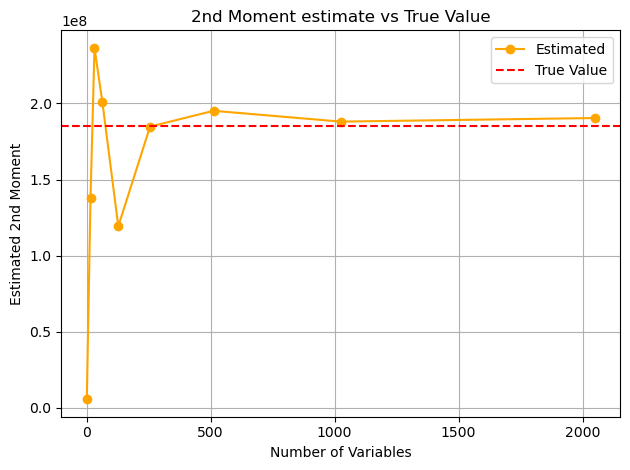

In [21]:
end_stream_moment_estimates = [estimates[-1] for estimates in second_moment_estimates]

plt.plot(parameters, end_stream_moment_estimates, marker='o', color='orange', label="Estimated")
plt.axhline(y=true_second_moments[-1], color='r', linestyle='--', label="True Value")
plt.title("2nd Moment estimate vs True Value")
plt.xlabel("Number of Variables")
plt.ylabel("Estimated 2nd Moment")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Mean squared error of the last 5 2nd moment estimates for each estimator (different number of variables)

In [22]:
from sklearn.metrics import mean_squared_error
print("2nd moment mse",[mean_squared_error(true_second_moments[-5:],e[-5:]) for e in second_moment_estimates])
print("distinct mse",[mean_squared_error(true_distincts[-5:],e[-5:]) for e in distinct_estimates])


2nd moment mse [3.2162637694597548e+16, 2278214292992048.0, 2598563505010677.5, 222929982314992.4, 4286080409615182.5, 188419236911.6, 98788494673048.4, 6627396359087.4, 23344943863118.6]
distinct mse [299275518122.0, 687587800029.2, 5613589784336.4, 1831948701046.8, 1658838817347.6, 1338388853725.2, 2323098317789.2, 1642117424912.4, 2127654604150.8]


# 2nd, 3rd and 4th moment estimate at the end of the stream with 2048 variables

In [23]:
print("2nd moment estimate:{:,}".format(moment_estimators[-1].get_estimate(2)))
print("2nd moment:{:,}".format(sum([v ** 2 for v in count.values()])))
print("3rd moment estimate:{:,}".format(moment_estimators[-1].get_estimate(3)))
print("3rd moment:{:,}".format(sum([v ** 3 for v in count.values()])))
print("4th moment estimate:{:,}".format(moment_estimators[-1].get_estimate(4)))
print("4th moment:{:,}".format(sum([v ** 4 for v in count.values()])))


2nd moment estimate:190,737,295
2nd moment:185,519,056
3rd moment estimate:25,035,464,731
3rd moment:20,853,698,024
4th moment estimate:10,124,079,362,426
4th moment:5,011,663,909,156


# Execution times of the functions to update variables/tail lengths and computing estimates

In [24]:
import time
start_time = time.time()
moment_estimators[-1].update_variables("test")
print("moment estimator update 2048 variables --- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
moment_estimators[-1].get_estimate(2)
print("2nd moment estimate computation 2048 variables --- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
distinct_estimators[-1].update_tail_lengths("test")
print("distinct estimator update tail lengths 2048 hash--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
distinct_estimators[-1].get_estimate(2)
print("distinct estimate computation 2048 hash --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
distinct_estimators[-3].update_tail_lengths("test")
print("distinct estimator update tail lengths 512 hash--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
moment_estimators[-3].update_variables("test")
print("moment estimator update 512 variables --- %s seconds ---" % (time.time() - start_time))

moment estimator update 2048 variables --- 0.0008304119110107422 seconds ---
2nd moment estimate computation 2048 variables --- 0.0013840198516845703 seconds ---
distinct estimator update tail lengths 2048 hash--- 0.001665353775024414 seconds ---
distinct estimate computation 2048 hash --- 0.00539708137512207 seconds ---
distinct estimator update tail lengths 512 hash--- 0.00024127960205078125 seconds ---
moment estimator update 512 variables --- 0.00023102760314941406 seconds ---
